In [1]:
#import RNA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from Bio.Seq import Seq
from Bio import motifs
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D

import sklearn
from sklearn.linear_model import LogisticRegression

import scanpy as sc

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'

Using TensorFlow backend.


# Original Author Model

For background, so we know what we're trying to predict

## Data And Model Setup

In [2]:
def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model


def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))   #LAE: .values added, pd deprecation
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df

def test_binary_data(df, model, test_seq, obs_col, output_col='pred'):
    # No need to scale since values already are all 0 or 1
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = predictions
    df.loc[:,output_col+'_error'] = df[obs_col] - df[output_col]
    return df


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

In [3]:
## Read in Sequence Data

#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv',index_col=0)
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

In [4]:
## Calculate MFE by position for each sequence and save (COMPUTATIONALLY INTENSIVE!)

get_mfe = lambda s: RNA.fold(s)[1] #check if this should be fold or LFold !!!
upstream_constant = "GGGACATCGTAGAGAGTCGTACTTA"
eGFP = "ATGGGCGAATTAAGTAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCAAGCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTTCGAATAAAGCTAGC"
downstream_addition = "GCCTCGACTGTGCCTTCTAGTTGCCAGCCATCTGTTGTTTG"
HEADER_LEN = len(upstream_constant)

def positional_mfe(seq,index,span):
    subseq = seq[index-(span/2):index+(span/2)+1]
    return get_mfe(subseq)

def mfe_encode(df, col='utr', seq_len=50, span=40): #spans over ~50 overflow upstream
    vectors=np.empty([len(df),seq_len])
    for i,seq in enumerate(df[col].str[:seq_len]): 
        s = upstream_constant+seq+eGFP
        # Calculate MFE at every position
        a = np.array([ positional_mfe(s,s_ind,span) for s_ind in np.arange(HEADER_LEN,seq_len+HEADER_LEN) ])
        vectors[i] = a
        if (i+1) % 1000 == 0:
            print( i+1 )
    return vectors   

# Load Positional MFE Data
mfe_df = pd.read_csv('./saved_data/positional_mfe.csv')
mfe_arr = mfe_df.values
df['positional_mfe'] = list(mfe_arr[:,1:51])
df['scaled_mfe'] = list(preprocessing.StandardScaler().fit_transform(mfe_arr[:,1:51]))

# EXPENSIVE CALCULATIONS
# mfe_e_train = mfe_encode(e_train,seq_len=50,span=40)
# mfe_e_test = mfe_encode(e_test,seq_len=50,span=40)

# Save MFE Calculations
# mfe_total = np.concatenate([mfe_e_test,mfe_e_train]) #reconstruct original order
# utrs = df['utr'].values
# mfe_df = pd.DataFrame(mfe_total)
# mfe_df.loc[:,'utr'] = utrs
# mfe_df.to_csv('./saved_data/positional_mfe.csv')

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
## Split the Train and Test Datasets

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:20000]
e_train = df.iloc[20000:]

# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale the training mean ribosome load values
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

# Label the datasets
e_train.loc[:,'dataset'] = 'train'
e_test.loc[:,'dataset'] = 'test'

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Load Original Model

In [6]:
# Load Saved Model
model = keras.models.load_model('./saved_models/main_MRL_model.hdf5') #this is the Author's model

In [7]:
e_train = test_data(df=e_train,model=model,test_seq=seq_e_train,obs_col='rl',output_col='auth_pred')
e_test = test_data(df=e_test,model=model,test_seq=seq_e_test,obs_col='rl',output_col='auth_pred')

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Visualize Original Model Results

In [8]:
def jointgrid_plot(datasets,one_dataset=False,colors=[(0.3, 0.45, 0.69),'r'],title="",alphas=[0.1,0.1],
                   xheader='rl',yheader='pred',xaxislabel='Observed MRL',yaxislabel="Predicted MRL"):
    """
    Make a jointgrid scatter plot of Observed MRL vs Predicted MRL using two or more different datasets 
    colored according to the input list of colors, in a style like the author's figure. 
    If only one dataset, set the flag one_dataset to True so that datasets can be of type list without 
    getting datasets vs dataset elements confused. Bad code but hey.
    """
    data = datasets if one_dataset == True else datasets[0]
    
    g = sns.JointGrid(x=xheader, y=yheader, data=data, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
    g.plot_joint(plt.scatter,s=20, color=colors[0], linewidth=0.2, alpha=str(alphas[0]), edgecolor='white')
    f = g.fig
    ax = f.gca()
    ax.set_yticks(np.arange(0,9.01, 1));
    ax.set_yticklabels(range(10),size=20);
    ax.set_xticks(np.arange(1,10.01, 1));
    ax.set_xticklabels(range(1,11),size=20);
    ax.set_ylim(0,9)
    ax.set_xlim(1,10)
    g.plot_marginals(sns.kdeplot,shade=colors[0], **{'linewidth':2, 'color':colors[0]})
    g.set_axis_labels(xaxislabel, yaxislabel, **{'size':22});

    if one_dataset == False:
        alphas = alphas if len(alphas) == len(datasets) else [alphas[0]]*len(datasets)
        for d,c,a in zip(datasets[1:],colors[1:],alphas[1:]):
            g.x = d[xheader].values
            g.y = d[yheader].values
            g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha=str(a), color=c, edgecolor='white')
            g.plot_marginals(sns.kdeplot, shade=c, **{'linewidth':2, 'color':c})
            f = g.fig

    f.suptitle(title,fontsize=20)
    
    return f

In [97]:
e_test.head(2)

,utr,0,1,2,3,4,5,6,7,8,...,r9,r10,r11,r12,r13,rl,positional_mfe,scaled_mfe,dataset,auth_pred
0,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA,0.000137,0.000109,0.000057,0.000033,0.000015,0.000016,0.000009,0.000009,0.000008,...,0.019283,0.033252,0.033252,0.027581,0.035877,3.039939,"[-3.7999999523162837, -3.7999999523162837, -3.7999999523162837, -3.7999999523162837, -3.79999995...","[0.6347199954714933, 0.7047162513272675, 0.7267889106190696, 0.7305602916327165, 0.6859155538794...",test,1.797135
1,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT,0.000067,0.000070,0.000065,0.000048,0.000023,0.000020,0.000011,0.000011,0.000010,...,0.024241,0.039457,0.039457,0.039840,0.038785,3.895109,"[-4.900000095367432, -6.5999999046325675, -7.5999999046325675, -5.800000190734862, -4.9000000953...","[0.19685044743718183, -0.3941997979428325, -0.7527906857253384, -0.0438228235011703, 0.267559750...",test,2.899773


/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


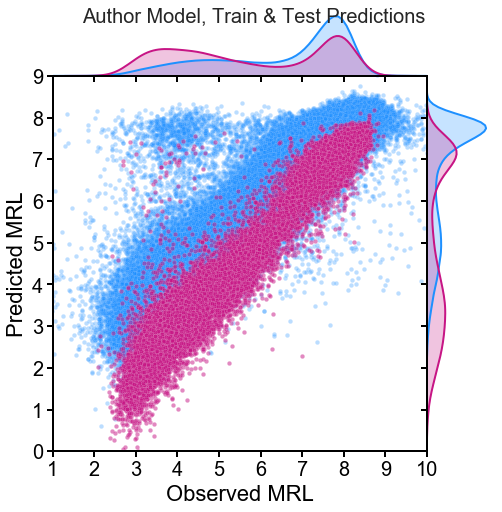

In [9]:
plot_auth = jointgrid_plot([e_train,e_test],alphas=[0.3,0.5],yheader='auth_pred',colors=['dodgerblue','mediumvioletred'],
                           title="Author Model, Train & Test Predictions")

## Visualize Off-Diagonal Cluster to be Predicted

In [10]:
# Combine Datasets so that we can split on different concepts
data = pd.concat([e_train,e_test],axis=0,sort=True)
data.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(data.loc[:,'rl'].values.reshape(-1,1))
data.loc[:,'scaled_total_reads'] = preprocessing.StandardScaler().fit_transform(data.loc[:,'total_reads'].values.reshape((-1,1)))


In [11]:
# Add MFE Data Now (for later usage)
# static_mfe_data = pd.read_csv('../mfe_dataset.csv',index_col=0)
# data.sort_values(by='utr',inplace=True, ascending=False)
# static_mfe_data.sort_values(by='utr',inplace=True, ascending=False)
# data.loc[:,'mfe75'] = mfe_data['mfe75']
# data.loc[:,'mfe100'] = mfe_data['mfe100']
# data.loc[:,'mfe125'] = mfe_data['mfe125']

# # Scale a few key values (for later usage)
# for header in ['total_reads','mfe75','mfe100','mfe125']:
#     scaler = preprocessing.StandardScaler()    
#     data.loc[:,'scaled_'+header] = scaler.fit_transform(data.loc[:,header].values.reshape((-1,1)))

data.sort_values(by='total_reads',inplace=True, ascending=False)

In [12]:
# Isolate that off-diagonal "cluster" of low observed/high predicted MRL (Generous boundaries)
ofd = data[((data['auth_pred']-data['rl'])**2 > 3.5)
                  &(data['auth_pred']-data['rl'] > 0)
                  &(data['auth_pred'] > 6.5)] 
ond = data[~data['utr'].isin(ofd['utr'].values)]
print( len(ofd), len(ond), len(ofd[ofd['dataset'] == 'test']))
data.loc[:,'off_diagonal'] = [ s in ofd['utr'].values for s in data['utr'].values ]

1281 278719 37


/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


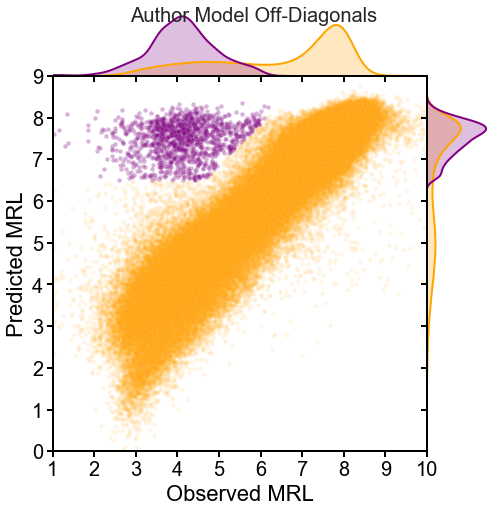

In [13]:
plot_auth2 = jointgrid_plot([ond,ofd],alphas=[0.1,0.3],yheader='auth_pred',
                            colors = ['orange','purple'],
                            title="Author Model Off-Diagonals")

# Create Secondary Predictor
Try to predict class membership in "purple" vs "orange" in the above graph

## Goal: To Create a Model that Predicts Off-Diagonal Cluster Membership

- will require upsampling of the minority class (off-diagonal cluster elements), and maybe downsampling of majority class as well
- create both a smaller version of the main model that has no additional information, AND an alternate model that uses derived filter information and other info like MFE and read count

In [14]:
def count_results(df,xheader,yheader):
    d = { "true_pos":0,"true_neg":0,"false_pos":0,"false_neg":0, "total":0 }
    labels = df[xheader].values
    predictions = df[yheader].values
    rounded_predictions = np.round(predictions,1) #really basic, ignores lots of subtle errors
    d['total'] = len(labels)
    for l,p in zip(labels,rounded_predictions):
        if l == 1: # is truly pos
            if p == l:
                d['true_pos'] += 1
            else:
                d['false_neg'] += 1
        elif l == 0: # is truly neg
            if p == l:
                d['true_neg'] += 1
            else:
                d['false_pos'] += 1
        else:
            print( "label not recognized")
            return 
    return d

### Create Train and Test Datasets for the ODC

In [104]:
# Create Test and Train Sets
ofd.sort_values('total_reads', inplace=True, ascending=False)
ofd.reset_index(inplace=True, drop=True)
ond.sort_values('total_reads', inplace=True, ascending=False)
ond.reset_index(inplace=True, drop=True)

ofd.loc[:,'off_diagonal'] = 1
ond.loc[:,'off_diagonal'] = 0

In [117]:
# Test set does not really need to be balanced, 
# if we be sure to also performance on the off-diagonal UTRs set specifically
X_test = pd.concat([ ofd[:281],ond[:19719]], axis=0, sort=True)
X_test_minority = ofd[:281]

# Train set DOES need to be balanced, however. 
# 200k seqences in total:
#     100k of 1k off-diagonals upsampled 100x
#     100k of 50k high-read-count on-diagonals + 50k low-read-count on-diagonals
X_train = pd.concat( [ pd.concat([ofd[281:]]*100), ond[19719:69719], ond[-50000:] ], axis=0, sort=True)
# Small Train Set with only 20k values
X_small_train = pd.concat( [ pd.concat([ofd[281:]]*10), ond[19719:24719], ond[-15000:-10000] ], axis=0, sort=True)
X_train_tiny = pd.concat( [ofd[281:],ond[19719:20719]], axis=0, sort=True) #no upsampling, only downsampling

In [118]:
# Shuffle order of Train Set
np.random.seed(42)
X_train = X_train.sample(frac=1)
X_small_train = X_small_train.sample(frac=1)
X_train_tiny = X_train_tiny.sample(frac=1)

X_train_seq = one_hot_encode(X_train)
X_small_train_seq = one_hot_encode(X_small_train)
X_train_tiny_seq = one_hot_encode(X_train_tiny)
X_test_seq = one_hot_encode(X_test)
X_test_minority_seq = X_test_seq[:281]

y_train = X_train['off_diagonal'].values
y_small_train = X_small_train['off_diagonal'].values
y_train_tiny = X_train_tiny['off_diagonal'].values
y_test = X_test['off_diagonal'].values

## Make Small Model with No Additional Information than Main Model

In [119]:
# Build the Smaller Model 
# 30 filters of kernel length 8 x 2 layers
# 20 nodes in dense layer
small_model = Sequential()
small_model.add(Conv1D(activation="relu", input_shape=(50, 4), padding="same",
                       filters=5, kernel_size=8))
small_model.add(Conv1D(activation="relu", input_shape=(50, 1), padding="same",
                       filters=5, kernel_size=8))
small_model.add(Flatten())
small_model.add(Dense(10))
small_model.add(Activation('relu'))
small_model.add(Dropout(0.0))
small_model.add(Dense(1))
small_model.add(Activation('hard_sigmoid')) #sigmoid outputs an approximately binary classification 


In [121]:
# Compile and Train the Smaller Model
np.random.seed(1337)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
small_model.compile(loss='mean_squared_error', optimizer=adam)

small_model.fit(X_train_tiny_seq, y_train_tiny, batch_size=125, epochs=50, verbose=1) 
#changed batch size 128 -> 125 for even split

Epoch 1/50
2000/2000 [==============================] - 0s 131us/step - loss: 0.2467
Epoch 2/50
2000/2000 [==============================] - 0s 44us/step - loss: 0.2442
Epoch 3/50
2000/2000 [==============================] - 0s 45us/step - loss: 0.2420
Epoch 4/50
2000/2000 [==============================] - 0s 53us/step - loss: 0.2399
Epoch 5/50
2000/2000 [==============================] - 0s 44us/step - loss: 0.2367
Epoch 6/50
2000/2000 [==============================] - 0s 51us/step - loss: 0.2340
Epoch 7/50
2000/2000 [==============================] - 0s 42us/step - loss: 0.2311
Epoch 8/50
2000/2000 [==============================] - 0s 45us/step - loss: 0.2300
Epoch 9/50
2000/2000 [==============================] - 0s 48us/step - loss: 0.2274
Epoch 10/50
2000/2000 [==============================] - 0s 47us/step - loss: 0.2249
Epoch 11/50
2000/2000 [==============================] - 0s 44us/step - loss: 0.2215
Epoch 12/50
2000/2000 [==============================] - 0s 47us/step - l

## Test Small Model Meta-Predictions

In [126]:
X_train_tiny = test_binary_data(df=X_train_tiny,model=small_model,test_seq=X_train_tiny_seq,obs_col='off_diagonal',output_col='small_pred')


In [127]:
X_test = test_binary_data(df=X_test,model=small_model,test_seq=X_test_seq,obs_col='off_diagonal',output_col='small_pred')
X_test_minority = test_binary_data(df=X_test_minority,model=small_model,
                            test_seq=X_test_minority_seq,obs_col='off_diagonal',output_col='small_pred_min')

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Percent below 0.5: 0.5025 %
Percent above 0.5: 0.4975 %
Percent with Error below 0.2: 0.3345 %


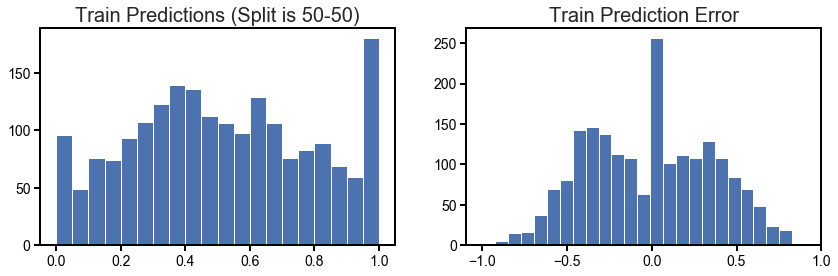

In [129]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14,4))
ax1.hist(X_train_tiny['small_pred'],bins=20)
ax1.set_title("Train Predictions (Split is 50-50)",fontsize=20)
print( "Percent below 0.5:", len(X_train_tiny[X_train_tiny['small_pred'] < 0.5]) * 100.0 / len(X_train), '%')
print( "Percent above 0.5:", len(X_train_tiny[X_train_tiny['small_pred'] >= 0.5]) * 100.0 / len(X_train), '%')

ax2.hist(X_train_tiny['small_pred_error'],bins=25)
ax2.set_title("Train Prediction Error",fontsize=20)
pct = len(X_train_tiny[np.abs(X_train_tiny['small_pred_error']) < 0.2]) * 100.0 / len(X_train)
print( "Percent with Error below 0.2:", pct, '%')

Percent below 0.5: 53.765 %
Percent above 0.5: 46.235 %
Percent with Error below 0.2: 16.49 %


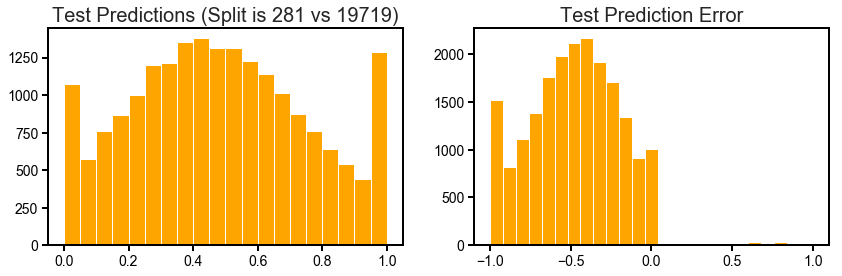

In [125]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14,4))
ax1.hist(X_test['small_pred'],bins=20,color='orange')
ax1.set_title("Test Predictions (Split is 281 vs 19719)",fontsize=20)
print( "Percent below 0.5:", len(X_test[X_test['small_pred'] < 0.5]) * 100.0 / len(X_test), '%')
print( "Percent above 0.5:", len(X_test[X_test['small_pred'] >= 0.5]) * 100.0 / len(X_test), '%')

ax2.hist(X_test['small_pred_error'],bins=25,color='orange')
ax2.set_title("Test Prediction Error",fontsize=20)
pct = len(X_test[np.abs(X_test['small_pred_error']) < 0.2]) * 100.0 / len(X_test)
print( "Percent with Error below 0.2:", pct, '%')

Percent below 0.5 77.58007117437722 %
Percent above 0.5 22.419928825622776 %
Percent with Error below 0.2: 8.540925266903914 %


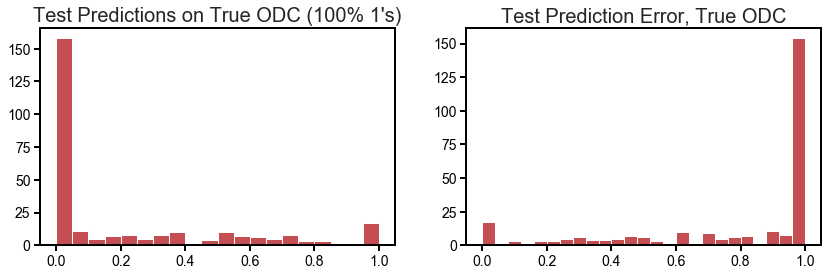

In [113]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14,4))
ax1.hist(X_test_minority['small_pred_min'],bins=20,color='r')
ax1.set_title("Test Predictions on True ODC (100% 1's)",fontsize=20)
print( "Percent below 0.5", len(X_test_minority[X_test_minority['small_pred_min'] < 0.5]) * 100.0 / len(X_test_minority), '%')
print( "Percent above 0.5", len(X_test_minority[X_test_minority['small_pred_min'] >= 0.5]) * 100.0 / len(X_test_minority), '%')

ax2.hist(X_test_minority['small_pred_min_error'],bins=25,color='r')
ax2.set_title("Test Prediction Error, True ODC",fontsize=20)
pct = len(X_test_minority[np.abs(X_test_minority['small_pred_min_error']) < 0.2]) * 100.0 / len(X_test_minority)
print( "Percent with Error below 0.2:", pct, '%')

In [114]:
rd = count_results(X_test,'off_diagonal','small_pred')
print( rd)
print( "% correct", 100.0 * (rd['true_pos']+rd['true_neg']) / rd['total']*1.0)

{'true_pos': 17, 'true_neg': 11277, 'false_pos': 8442, 'false_neg': 264, 'total': 20000}
% correct 56.47


In [115]:
rd = count_results(X_test_minority,'off_diagonal','small_pred_min')
print( rd)
print( "% correct", 100.0 * (rd['true_pos']+rd['true_neg']) / rd['total']*1.0)

{'true_pos': 17, 'true_neg': 0, 'false_pos': 0, 'false_neg': 264, 'total': 281}
% correct 6.049822064056939


## Results: Hmm. Not great

Doesn't seem to predict the minority class well, despite the up/down sampling, on either train set (the 20k with less repetition or the 200k with 200x repetition of each off-diagonal element)

# Model With More Information

What are the features?

Sequential:
- one-hot encoded sequence
- MFE of +/- 20 bp at each position
- ??

Single Number:
- Read count
- MFE of first 75, 100, 125 (previously computed)

Other:
- we could give it the polysome profile? or is that cheating? (MRL is calculated from the polysome profile)

### Get Data For the Model

In [130]:
def sequence_encode(df, seq_col='utr', n_col='scaled_mfe', seq_len=50):
    """Combines one-hot encoding with a sequential numerical features from the specified other column"""
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1], 'N':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,5])
    
    # Iterate through UTRs and one-hot encode
    seqs = df[seq_col].str[:seq_len]
    vals = df[n_col].values
    for i,(seq,val) in enumerate(zip(seqs,vals)): 
        for j,(s,v) in enumerate(zip(seq,val)):
            vectors[i][j][0:4] = nuc_d[s]
            vectors[i][j][4] = v
    return vectors

In [131]:
## Numeric Inputs
# X_train_n = X_train[['scaled_total_reads','scaled_mfe75','scaled_mfe100','scaled_mfe125']].values
# X_test_n = X_test[['scaled_total_reads','scaled_mfe75','scaled_mfe100','scaled_mfe125']].values
X_train_n = X_train[['scaled_total_reads']].values
X_test_n = X_test[['scaled_total_reads']].values

## Sequence Inputs
X_train_seq = sequence_encode(X_train,seq_col='utr',n_col='scaled_mfe',seq_len=50) 
X_test_seq = sequence_encode(X_test,seq_col='utr',n_col='scaled_mfe',seq_len=50)

In [132]:
y_train = X_train['off_diagonal']
y_test = X_test['off_diagonal']

### Create Mixed Input Model

In [133]:
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers import concatenate

In [134]:
def make_dense_branch(input_features=1,n_layers=2,n_filters=10,act_fn='relu',global_dropout=0.1,
                      n_output_features=5,last_activation='relu'):
    nn = Sequential()
    nn.add(Dense(n_filters,input_shape=(input_features,),activation='relu'))
    nn.add(Dropout(global_dropout))
    for _ in range(n_layers-1):
        nn.add(Dense(n_filters,input_shape=(input_features,),activation='relu'))
        nn.add(Dropout(global_dropout))
    nn.add(Dense(n_output_features,activation=last_activation))
    return nn


In [135]:
def make_cnn_branch(input_len=50,input_features=5,n_layers=3,n_filters=10,kernel_length=8,
                    border_pad="same",act_fn='relu',dense_nodes=30,dense_dropout=0.1,
                    n_output_features=10,last_activation="relu"):
    features_dim = -1 #which one of the height,width,depth tuple has the number of features? assume last one
    cnn = Sequential()
    cnn.add(Conv1D(activation=act_fn, input_shape=(input_len,input_features), padding=border_pad,
                       filters=n_filters, kernel_size=kernel_length))
    for _ in range(n_layers-1):
        cnn.add(Conv1D(activation=act_fn, input_shape=(input_len,1), padding=border_pad,
                           filters=n_filters, kernel_size=kernel_length))
    cnn.add(Flatten())
    cnn.add(Dense(dense_nodes,activation='relu'))
    cnn.add(Dropout(dense_dropout))
#     cnn.add(BatchNormalization(axis=-1)) #CHECK THIS
    cnn.add(Dense(n_output_features,activation=last_activation))
    return cnn


In [136]:
# Create the two upstream branches
dense_nn = make_dense_branch(input_features=1,n_layers=1,n_filters=3,n_output_features=1)
cnn = make_cnn_branch(n_layers=2,n_filters=8,kernel_length=7,dense_nodes=15,dense_dropout=0,n_output_features=5)

# Create the downstream merging layers
n_merge_nodes = 40
inputs_to_combined = concatenate([dense_nn.output,cnn.output])
last_dense_layers = Dense(n_merge_nodes, activation="relu")(inputs_to_combined)
last_dense_layers = Dense(1, activation="hard_sigmoid")(last_dense_layers)  # output single value, 
# 1 = predicted in ODC, 0 = predicted NOT in ODC

# Create the combined model
combined_model = Model(inputs=[dense_nn.input, cnn.input], outputs=last_dense_layers)


In [137]:
# # Compile and Train the Model
np.random.seed(1337)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
combined_model.compile(loss='mean_squared_error', optimizer=adam)

combined_model.fit([X_train_n,X_train_seq], y_train, batch_size=125, epochs=2, verbose=1) 

Epoch 1/2
200000/200000 [==============================] - 10s 52us/step - loss: 0.1364
Epoch 2/2
200000/200000 [==============================] - 10s 49us/step - loss: 0.0472


In [138]:
X_train = test_binary_data(df=X_train,model=combined_model,test_seq=[X_train_n,X_train_seq],
                           obs_col='off_diagonal',output_col='mix_pred')
X_test = test_binary_data(df=X_test,model=combined_model,test_seq=[X_test_n,X_test_seq],
                          obs_col='off_diagonal',output_col='mix_pred')

Percent below 0.5: 49.548 %
Percent above 0.5: 50.452 %
Percent with Error below 0.2: 93.7605 %


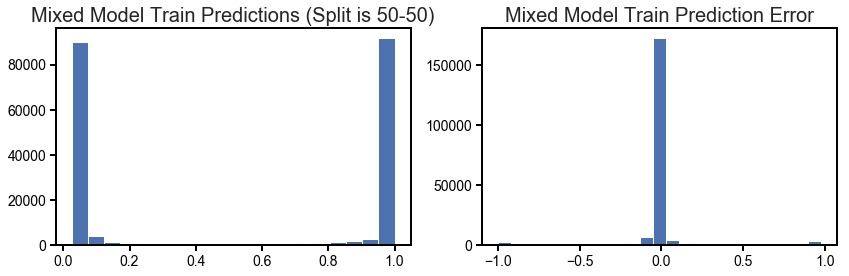

In [139]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14,4))
ax1.hist(X_train['mix_pred'],bins=20)
ax1.set_title("Mixed Model Train Predictions (Split is 50-50)",fontsize=20)
print( "Percent below 0.5:", len(X_train[X_train['mix_pred'] < 0.5]) * 100.0 / len(X_train), '%')
print( "Percent above 0.5:", len(X_train[X_train['mix_pred'] >= 0.5]) * 100.0 / len(X_train), '%')

ax2.hist(X_train['mix_pred_error'],bins=25)
ax2.set_title("Mixed Model Train Prediction Error",fontsize=20)
pct = len(X_train[np.abs(X_train['mix_pred_error']) < 0.2]) * 100.0 / len(X_train)
print( "Percent with Error below 0.2:", pct, '%')

Percent below 0.5: 94.31 %
Percent above 0.5: 5.69 %
Percent with Error below 0.2: 90.06 %


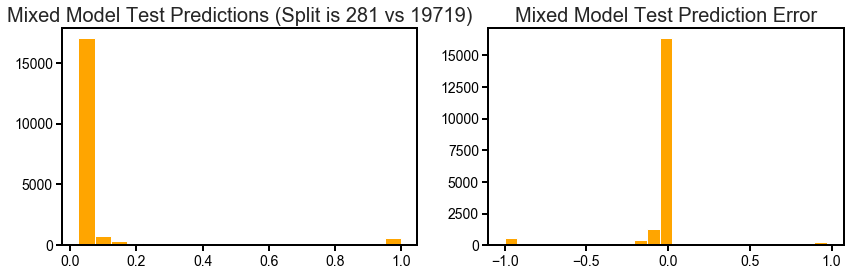

In [140]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14,4))
ax1.hist(X_test['mix_pred'],bins=20,color='orange')
ax1.set_title("Mixed Model Test Predictions (Split is 281 vs 19719)",fontsize=20)
print( "Percent below 0.5:", len(X_test[X_test['mix_pred'] < 0.5]) * 100.0 / len(X_test), '%')
print( "Percent above 0.5:", len(X_test[X_test['mix_pred'] >= 0.5]) * 100.0 / len(X_test), '%')

ax2.hist(X_test['mix_pred_error'],bins=25,color='orange')
ax2.set_title("Mixed Model Test Prediction Error",fontsize=20)
pct = len(X_test[np.abs(X_test['mix_pred_error']) < 0.2]) * 100.0 / len(X_test)
print( "Percent with Error below 0.2:", pct, '%')

In [141]:
X_test_odc = X_test[X_test['off_diagonal'] == 1]

Percent below 0.5 92.88256227758008 %
Percent above 0.5 7.117437722419929 %
Percent with Error below 0.2: 4.270462633451957 %


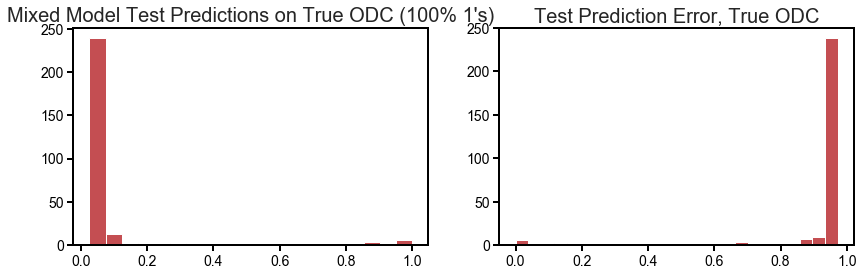

In [142]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14,4))
ax1.hist(X_test_odc['mix_pred'],bins=20,color='r')
ax1.set_title("Mixed Model Test Predictions on True ODC (100% 1's)",fontsize=20)
print( "Percent below 0.5", len(X_test_odc[X_test_odc['mix_pred'] < 0.5]) * 100.0 / len(X_test_minority), '%')
print( "Percent above 0.5", len(X_test_odc[X_test_odc['mix_pred'] >= 0.5]) * 100.0 / len(X_test_minority), '%')

ax2.hist(X_test_odc['mix_pred_error'],bins=25,color='r')
ax2.set_title("Test Prediction Error, True ODC",fontsize=20)
pct = len(X_test_odc[np.abs(X_test_odc['mix_pred_error']) < 0.2]) * 100.0 / len(X_test_minority)
print( "Percent with Error below 0.2:", pct, '%')

In [143]:
rd = count_results(X_test,'off_diagonal','mix_pred')
print( rd)
print( "% correct", 100.0 * (rd['true_pos']+rd['true_neg']) / rd['total']*1.0)

{'true_pos': 6, 'true_neg': 16284, 'false_pos': 3435, 'false_neg': 275, 'total': 20000}
% correct 81.45


In [144]:
rd = count_results(X_test_odc,'off_diagonal','mix_pred')
print( rd)
print( "% correct", 100.0 * (rd['true_pos']+rd['true_neg']) / rd['total']*1.0)

{'true_pos': 6, 'true_neg': 0, 'false_pos': 0, 'false_neg': 275, 'total': 281}
% correct 2.1352313167259784


In [145]:
data = pd.concat([X_test,X_train],axis=0,sort=True)
data.columns

Index(['0', '1', '10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8',
       '9', 'auth_pred', 'dataset', 'mix_pred', 'mix_pred_error',
       'off_diagonal', 'positional_mfe', 'r0', 'r1', 'r10', 'r11', 'r12',
       'r13', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'rl',
       'scaled_mfe', 'scaled_rl', 'scaled_total_reads', 'small_pred',
       'small_pred_error', 'total', 'total_reads', 'utr'],
      dtype='object')

In [152]:
mix_pred_ond = X_test[X_test['mix_pred'] < 0.3]
mix_pred_ofd = X_test[X_test['mix_pred'] > 0.7]
len(mix_pred_ond)

18505

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


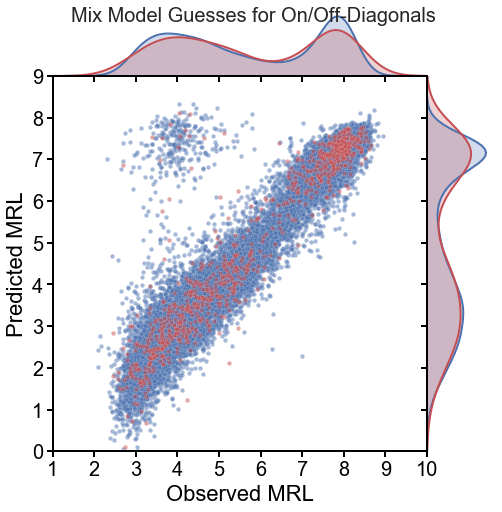

In [154]:
plot_auth2 = jointgrid_plot([mix_pred_ond,mix_pred_ofd],alphas=[0.5,0.5],yheader='auth_pred',
                            colors = ['b','r'],
                            title="Mix Model Guesses for On/Off-Diagonals")

In [86]:
import umap

NSAMPLES = 2000
mdata = mfe_arr[:,1:51]
ndata = mfe_arr[:NSAMPLES,1:51]

reducer = umap.UMAP(random_state=42,n_neighbors=10)

#data['rl'].values[:NSAMPLES]

In [87]:
embedding = reducer.fit_transform(ndata)

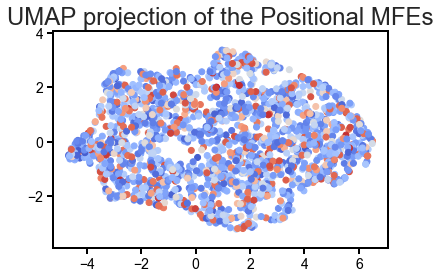

In [88]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=data['rl'].values[:NSAMPLES],cmap='coolwarm')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Positional MFEs', fontsize=24);

Note for later: you can put a validation set directly in the call to model.fit!!

In [ ]:
## EXAMPLE CODE
# model.fit(
# 	[trainAttrX, trainImagesX], trainY,
# 	validation_data=([testAttrX, testImagesX], testY),
# 	epochs=200, batch_size=8)